In [1]:
!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib wandb

In [2]:
import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import PeftModel
import matplotlib.pyplot as plt

In [3]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
HF_USER = "Tvbel"
PROJECT_RUN_NAME = "dissertation-model"
REVISION = None
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

DATASET_NAME = f"{HF_USER}/dissertation-dataset"

# Hyperparameters for QLoRA

QUANT_4_BIT = True

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [4]:
hf_token = userdata.get('colab-token')
login(hf_token, add_to_git_credential=True)

In [5]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
test[0]

{'text': 'How much does this cost to the nearest dollar?\n\nNavePoint 12U Wall-Mount Network Cabinet for 19 IT Equipment, A/V with Glass Door and Removable Side Panels, Locks, 2 Fans, 450mm Depth, Hinged Back\nDURABLE - The 12U NavePoint Swing Gate Series network cabinet is constructed from robust cold-rolled steel, reinforced with a resilient black powder coating. Supporting a maximum weight of 200 lbs, it serves as a dependable solution for network and server equipment, perfect for long-lasting installations. VERSATILE & SPACE EFFICIENT - This 12U server cabinet is compatible with 19 IT, server, and A/V equipment, making it adaptable to various project requirements. It can be conveniently utilized as a free-standing or wall-mounted unit, optimizing available space. Me\n\nPrice is $',
 'price': 384.39}

In [7]:
# 4 bit quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [8]:
# Loading the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Loading the fine-tuned model with PEFT
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

Memory footprint: 5700.6 MB


In [9]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

# Testing

In [10]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [11]:
extract_price("Price is $a fabulous 899.99 or so")

899.99

In [12]:
# This prediction function takes the most likely next token

def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [13]:
# This prediction function takes a weighted average of the top 3 choices

top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

In [14]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $337.00 Truth: $384.39 Error: $47.39 SLE: 0.02 Item: NavePoint 12U Wall-M...
2: Guess: $64.31 Truth: $62.43 Error: $1.88 SLE: 0.00 Item: Leviton OSFHP-ILW Co...
3: Guess: $61.62 Truth: $59.99 Error: $1.63 SLE: 0.00 Item: (Pack of 4) Metal Ha...
4: Guess: $72.62 Truth: $68.18 Error: $4.44 SLE: 0.00 Item: Araca VT85LP Project...
5: Guess: $120.19 Truth: $129.00 Error: $8.81 SLE: 0.00 Item: YUNZII Qeekestudio C...
6: Guess: $809.00 Truth: $716.87 Error: $92.13 SLE: 0.01 Item: Wrought Iron Vintage...
7: Guess: $295.75 Truth: $499.99 Error: $204.24 SLE: 0.27 Item: Samsung 1080p Blu-ra...
8: Guess: $259.50 Truth: $259.99 Error: $0.49 SLE: 0.00 Item: U-POL Raptor Bright ...
9: Guess: $59.19 Truth: $62.95 Error: $3.76 SLE: 0.00 Item: Radians Reversible W...
10: Guess: $129.12 Truth: $119.12 Error: $10.00 SLE: 0.01 Item: Renthal R3-3 SRS 520...
11: Guess: $18.52 Truth: $19.29 Error: $0.77 SLE: 0.00 Item: Brita Soft Squeeze W...
12: Guess: $108.12 Truth: $75.56 Error: $32.56 SLE: 0.13 

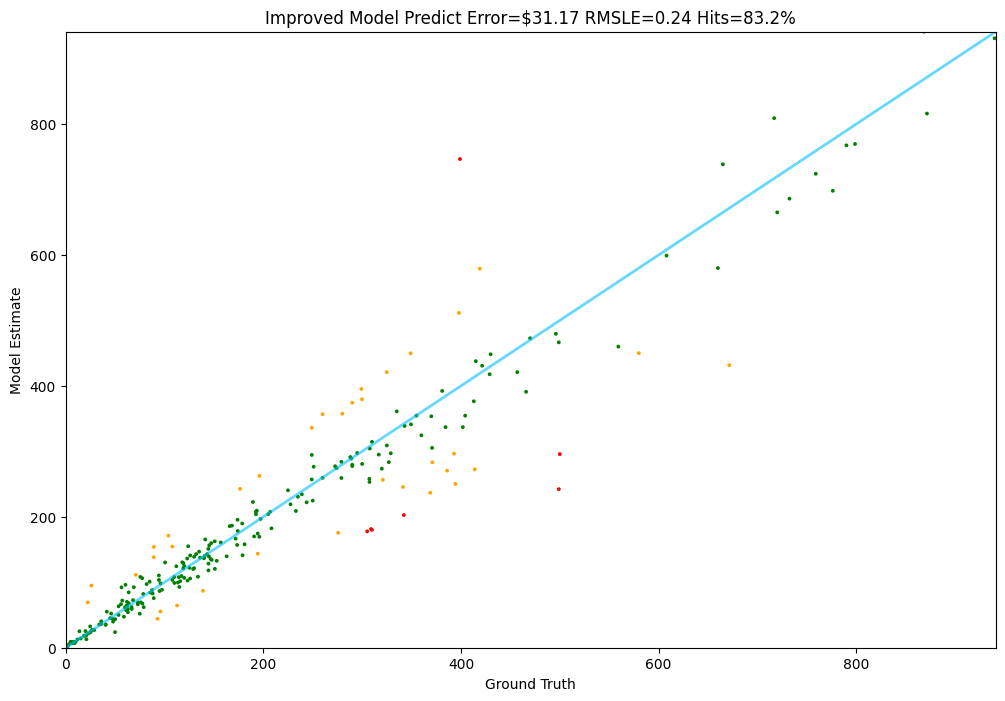

In [15]:
Tester.test(improved_model_predict, test)